# Train Test Split

Authors: Brian R. Mullen, Sero Toriano Parel, Revati Jadhav, Carrie Clark, Philip Nelson

Date: 2025-10-24

Python notebook exploring how to split the data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Load the cleaned data from EDA
cleaned_data_path = "../../emg_data/features_emg_data_cleaned.csv"
df_no_outliers = pd.read_csv(cleaned_data_path)
print(f"Loaded cleaned data: {df_no_outliers.shape}")

# Define feature columns (same logic as before)
metadata_cols = ['user', 'gesture', 'stage', 'is_outlier']
all_columns = df_no_outliers.columns.tolist()
feature_cols = [col for col in all_columns if col not in metadata_cols]
print(f"Feature columns: {len(feature_cols)}")


Loaded cleaned data: (125439, 164)
Feature columns: 160


We will be taking a 'personalized' approach, so data will be split for each individual user. 

To start, let's get a sense of how many times each user performed each gesture in each stage.

In [2]:
# add a column containing both stage and gesture
df_no_outliers['stage_gesture'] = df_no_outliers['stage']+'__'+df_no_outliers['gesture']

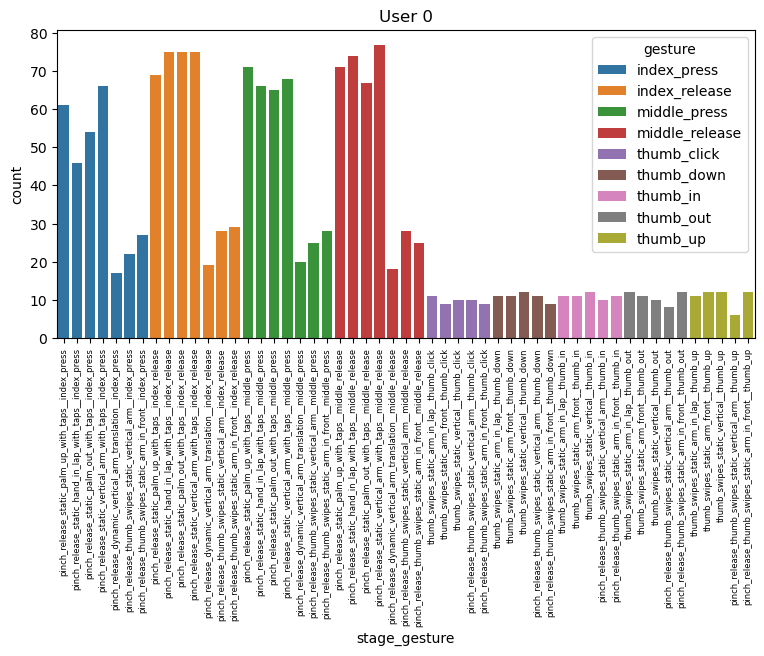

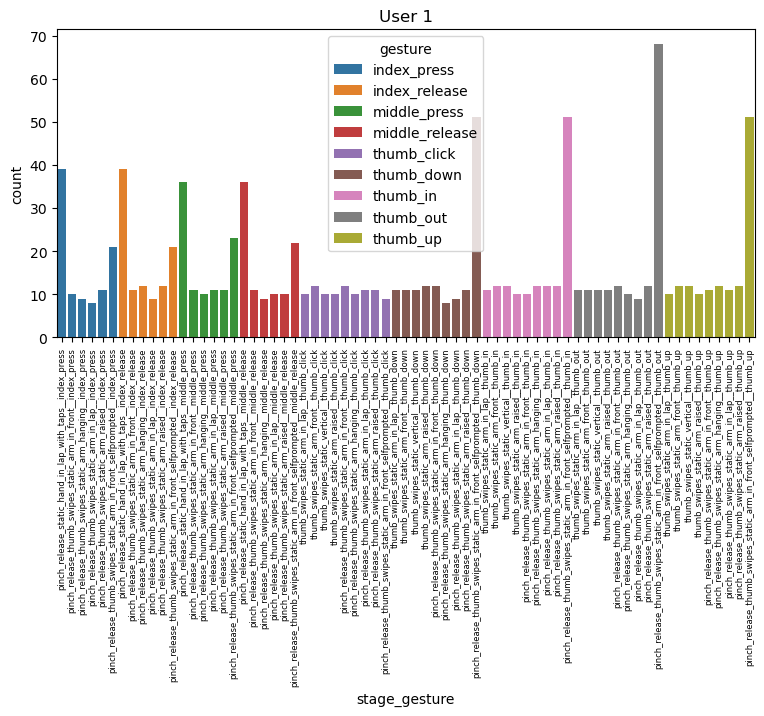

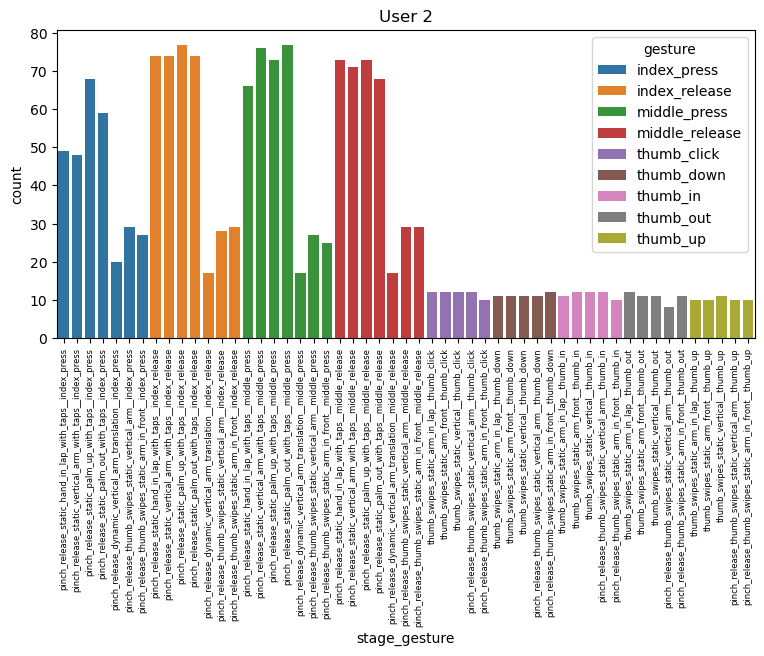

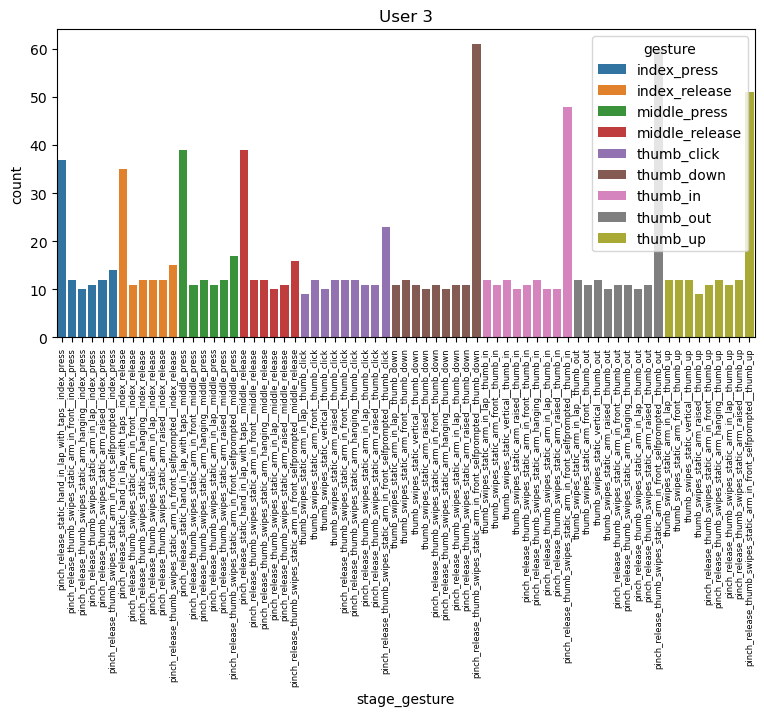

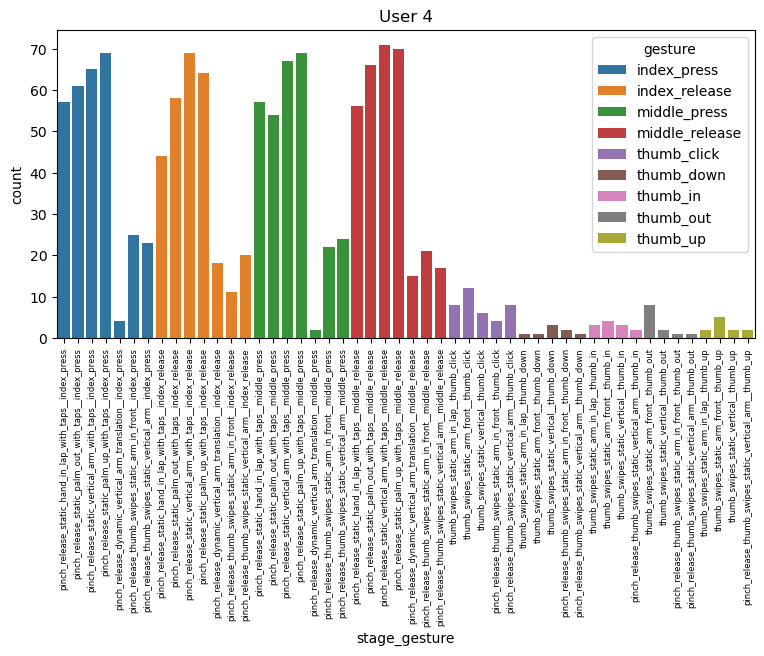

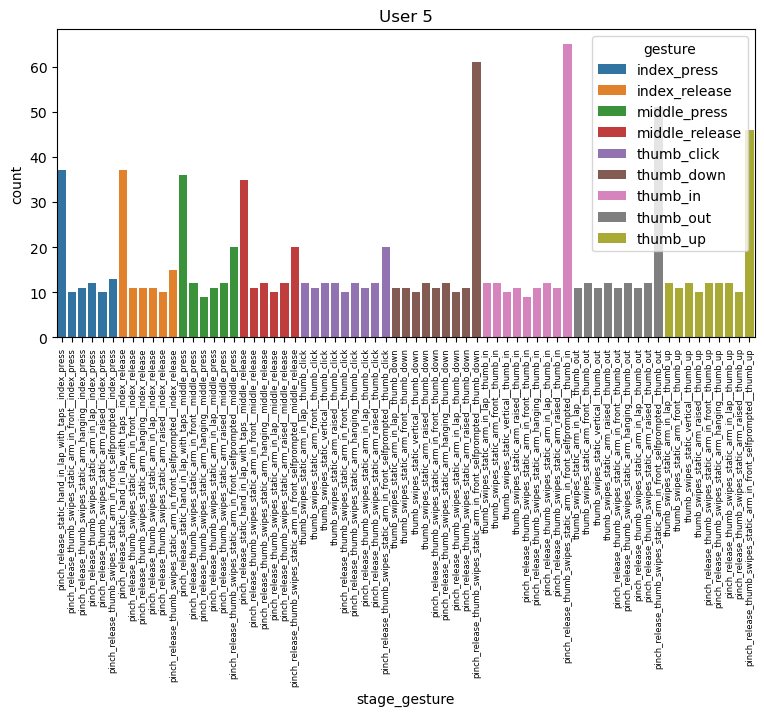

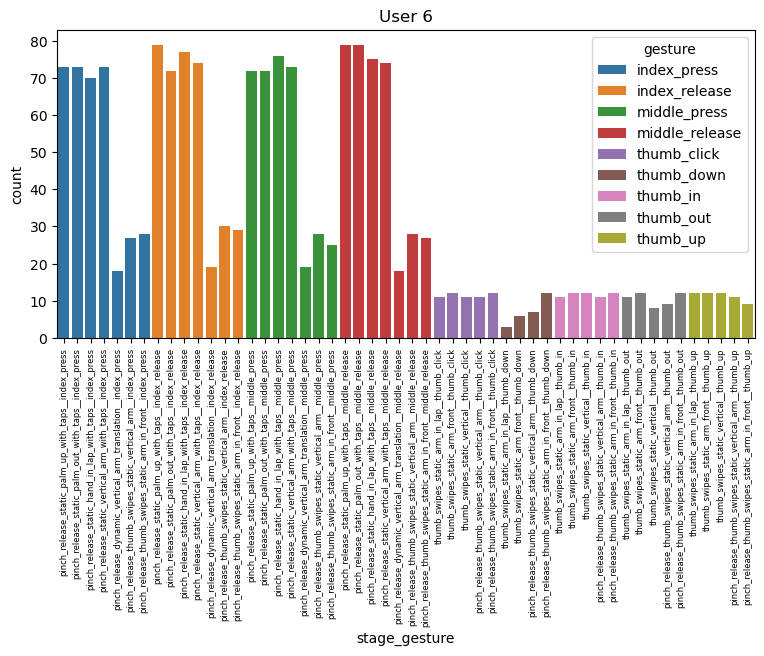

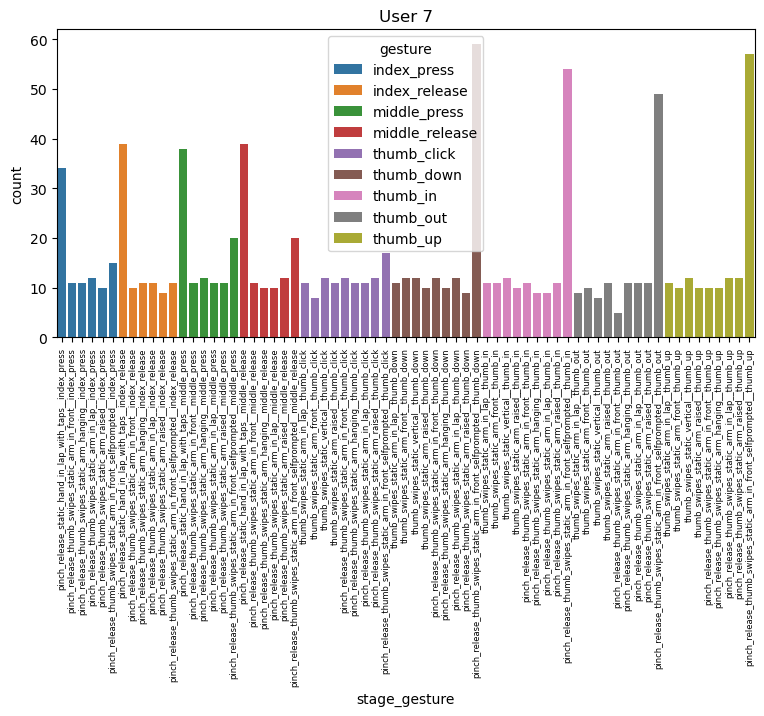

In [3]:
# count plots for each gesture-stage combination for the first eight users
for user_id in range(8):
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    
    fig, ax = plt.subplots(figsize=(9, 4)) 
    sns.countplot(data=user_data, x='stage_gesture', hue='gesture')
    plt.xticks(rotation=90,fontsize=6)
    plt.title('User '+str(user_id))
    plt.show()

Conclusion: the distribution of data between the different stages and gestures varies significantly between participants. 

# Two possible approaches to splitting:

- stratify by gesture and stage

- set aside a particular stage as the test data

# Stratifying for each user by gesture and stage

Note that some users have stage-gesture combinations with as few as 1 data point. From user-stage-gesture combinations with 2-4 data points, we set aside one for testing. User-stage-gesture combinations with only 1 data point are put in the training set. The rest of the data is split into 80% training, 20% testing, stratified by stage and gesture for each user separately.

In [4]:
# identify user-stage-gesture combinations with limited data points
# create new column
df_no_outliers['how_many_stage_gesture'] = 'many'

# check for user-stage-gesture combinations with fewer than 5 data points
for user_id in df_no_outliers['user'].unique():
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    for stage_gesture_name in user_data['stage_gesture'].unique():
        if 1 < user_data['stage_gesture'].value_counts()[stage_gesture_name] < 5:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'few'
        if user_data['stage_gesture'].value_counts()[stage_gesture_name] == 1:
            df_no_outliers.loc[(df_no_outliers['stage_gesture'] == stage_gesture_name) & (df_no_outliers['user'] == user_id),'how_many_stage_gesture'] = 'one'

# separate the data into three frames 
df_one_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'one']
df_few_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'few']
df_many_stage_gesture = df_no_outliers[df_no_outliers['how_many_stage_gesture'] == 'many']

# now we are ready to split the data using_train_test_split
from sklearn.model_selection import train_test_split

train_pieces, test_pieces = [], []

# split df_few_stage_gesture by keeping 1 data point for testing from each user-stage-gesture combination 
for user_id in df_few_stage_gesture['user'].unique():
    user_data = df_few_stage_gesture[df_few_stage_gesture['user'] == user_id]
    
    for stage_gesture in user_data.stage_gesture.unique():
        user_train = user_data[user_data['stage_gesture'] == stage_gesture].iloc[1:,:]
        user_test = user_data[user_data['stage_gesture'] == stage_gesture].iloc[[0]]
    
        train_pieces.append(user_train)
        test_pieces.append(user_test)

# split df_many_stage_gesture for each user, stratifying by stage and gesture 
for user_id in df_many_stage_gesture['user'].unique():
    user_data = df_many_stage_gesture[df_many_stage_gesture['user'] == user_id]
    
    # Split: 80% train, 20% test
    user_train, user_test = train_test_split(
        user_data, test_size=0.2, random_state=13, shuffle=True, stratify=user_data.stage_gesture
    )
    
    train_pieces.append(user_train)
    test_pieces.append(user_test)

# Combine all pieces
df_train = pd.concat(train_pieces+[df_one_stage_gesture])
df_test = pd.concat(test_pieces)

print(f"Original: {df_no_outliers.shape}")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Original: (125439, 166)
Train: (100257, 166)
Test: (25182, 166)


In [5]:
# DOUBLE CHECK

# Quick verification
print(f"# of users in both sets: {df_train['user'].nunique()}")

# Show sample user splits (first 10)
sample_data = []
for user_id in range(10):
    orig = len(df_no_outliers[df_no_outliers['user'] == user_id])
    calib = len(df_train[df_train['user'] == user_id])
    test = len(df_test[df_test['user'] == user_id])
    
    sample_data.append({
        'User': user_id,
        'Original': orig,
        'Train': f"{calib} ({calib/orig*100:.1f}%)",
        'Test': f"{test} ({test/orig*100:.1f}%)"
    })

display(pd.DataFrame(sample_data))

# of users in both sets: 100


,User,Original,Train,Test
0,0,1630,1304 (80.0%),326 (20.0%)
1,1,1071,856 (79.9%),215 (20.1%)
2,2,1669,1335 (80.0%),334 (20.0%)
3,3,1081,864 (79.9%),217 (20.1%)
4,4,1280,1019 (79.6%),261 (20.4%)
5,5,1082,865 (79.9%),217 (20.1%)
6,6,1738,1390 (80.0%),348 (20.0%)
7,7,1048,838 (80.0%),210 (20.0%)
8,8,1726,1380 (80.0%),346 (20.0%)
9,9,1076,860 (79.9%),216 (20.1%)


# Setting aside stage for testing

For this approach to work, we would need to identify which stage to set aside for testing. One option is to find a stage which contains all nine gestures, and a suitable proportion of each gesture. Let's check if this is possible with a test set of between 20% and 30%.

In [6]:
# empty dictionary for user ids and possible test stages
stage_candidates = {}
for user_id in df_no_outliers['user'].unique():
    user_data = df_no_outliers[df_no_outliers['user'] == user_id]
    for stage in user_data['stage'].unique():
        #check if stage has all nine gestures
        if len(user_data.loc[user_data['stage']==stage,'gesture'].unique()) == 9:
            #for each gesture, check if the stage contains a suitable proportion.
            for gesture in df_no_outliers['gesture'].unique():
                if 0.30 > len(user_data.loc[(user_data['stage']==stage) & (user_data['gesture']==gesture)])/len(user_data.loc[user_data['gesture']==gesture]) > 0.2:
                    if user_id in stage_candidates.keys():
                        stage_candidates[user_id] = stage_candidates[user_id]+[stage]
                    else:
                        stage_candidates[user_id]=[stage]

#how many users?
print('There are '+str(len(stage_candidates.keys()))+' users with at least one suitable choice for a test stage.')

There are 77 users with at least one suitable choice for a test stage.


# Generating figures for presentation

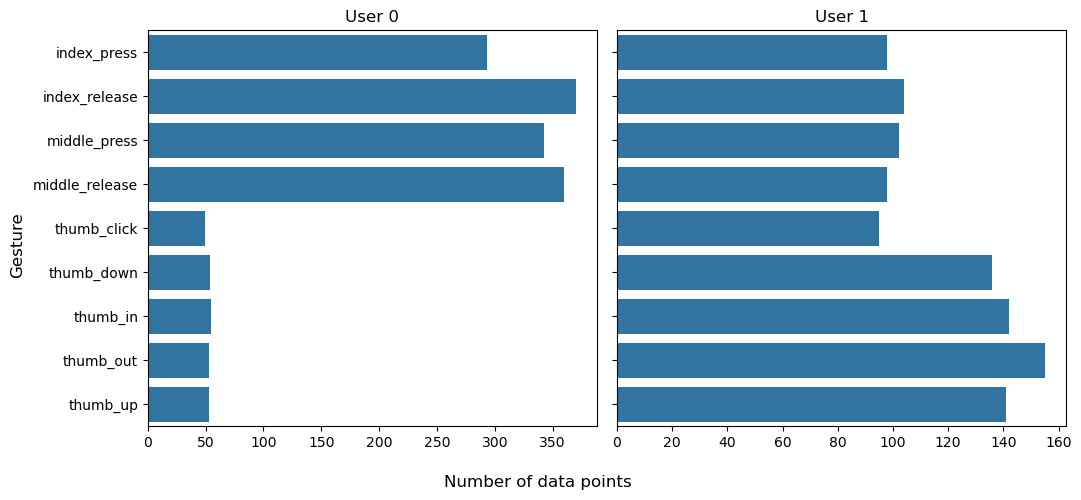

In [11]:
# count plots for each gesture for two particular users
fig, ax = plt.subplots(ncols=2,figsize=(11,5),sharey=True) 
fig.supxlabel('Number of data points')
fig.supylabel('Gesture')

for i in range(2):
    user_data = df_no_outliers[df_no_outliers['user'] == i]
    
    sns.countplot(data = user_data, y = 'gesture', ax=ax[i])

    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_title('User '+str(i))

plt.tight_layout()
fig.savefig('../images/data_distribution_btw_gestures.png')
plt.show()